In [7]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pymc.sampling_jax
import numpy as np
import scipy as sp
import lifelines
from sklearn.model_selection import train_test_split

# Load data

In [3]:
data = pd.read_csv("../data/veteran.csv")

In [4]:
data

,time,status,karno,diagtime,age,prior,trt,celltype
0,72,1,60,7,69,0,1,1
1,411,1,70,5,64,10,1,1
2,228,1,60,3,38,0,1,1
3,126,1,60,9,63,10,1,1
4,118,1,70,11,65,10,1,1
...,...,...,...,...,...,...,...,...
132,133,1,75,1,65,0,2,4
133,111,1,60,5,64,0,2,4
134,231,1,70,18,67,10,2,4
135,378,1,80,4,65,0,2,4


In [89]:
X = data[['age', 'trt']].copy()
X['celltype_1'] = data['celltype'] == 1
X['celltype_2'] = data['celltype'] == 2
X['celltype_3'] = data['celltype'] == 3
X['celltype_4'] = data['celltype'] == 4
X['prior'] = data['prior'] == 10
X['karno'] = data['karno']
X['trt'] = data['trt'] == 2
X['diagtime'] = data['diagtime']

X = X[['celltype_1', 'celltype_2', 'celltype_3', 'trt']]

y = data[['time', 'status']].values
y[:, 1] = 1 - y[:, 1]  # inverse

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.astype(float)
y_train = y_train.astype(float)
X_test = X_test.values.astype(float)
y_test = y_test.astype(float)

n_predictors = X_train.shape[1]

In [21]:
print(X_train.shape)
print(y_train.shape)

(109, 9)
(109, 2)


In [62]:
np.repeat(25, 9)

array([25, 25, 25, 25, 25, 25, 25, 25, 25])

In [126]:
with pm.Model() as model:
    model_input = pm.MutableData("model_input", X_train)
    if y_train is not None:
        time_censor_ = pm.MutableData("time_censor", y_train[y_train[:, 1] == 1, 0])
        time_uncensor_ = pm.MutableData("time_uncensor", y_train[y_train[:, 1] == 0, 0])
        censor_ = pm.MutableData("censor", y_train[:, 1].astype(np.int8))
        predict_ = pm.MutableData('predict', True)

    ell = pm.InverseGamma("ell",
                          mu=2.0,
                          sigma=0.5,
                          shape=n_predictors)
    eta = pm.Exponential("eta",
                         lam=1.0)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(input_dim=n_predictors, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)
    # gp = pm.gp.HSGP(m=np.repeat(25, 9), cov_func=cov)
    f = gp.prior("f", X=model_input)

    lambda_intercept = pm.Normal("lambda_intercept",
                                 mu=0,
                                 sigma=1)

    lambda_det = pm.Deterministic("lambda_det", pm.math.exp(lambda_intercept + f))
    # lambda_det = pm.math.exp(lambda_intercept + f)

    if predict_:
        censored_ = pm.math.eq(censor_, 1)
        y_ = pm.Exponential("y", pm.math.ones_like(time_uncensor_) / lambda_det[~censored_],
                            observed=time_uncensor_)

        def exponential_lccdf(lam, time):
            """ Log complementary cdf of Exponential distribution. """
            return -(lam * time)

        y_cens = pm.Potential(
            "y_cens",
            exponential_lccdf(pm.math.ones_like(time_censor_) / lambda_det[censored_],
                              time_censor_)
        )
        
    trace = pm.sample(draws=500, tune=250, chains=2, nuts_sampler='nutpie')

/usr/local/lib/python3.8/dist-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/usr/local/lib/python3.8/dist-packages/pymc/util.py:499: FutureWarning: The tag attribute observations is deprecated. Use model.rvs_to_values[rv] instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytensor/link/numba/dispatch/basic.py:363: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytensor/link/numba/dispatch/basic.py:363: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytensor/link/numba/dispatch/basic.py:363: UserWarning: Numba will use object mode to run AdvancedSubtensor's perform method
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytensor/link/numba/dispatch

In [127]:
az.summary(trace, var_names=['~ell_log__', '~lambda_det', '~f_rotated_', '~f', '~ell'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta_log__,0.774,0.287,0.236,1.312,0.073,0.053,16.0,128.0,1.11
lambda_intercept,1.120,0.938,-0.441,2.983,0.094,0.067,99.0,202.0,1.03
eta,2.257,0.641,1.104,3.397,0.154,0.111,16.0,128.0,1.11


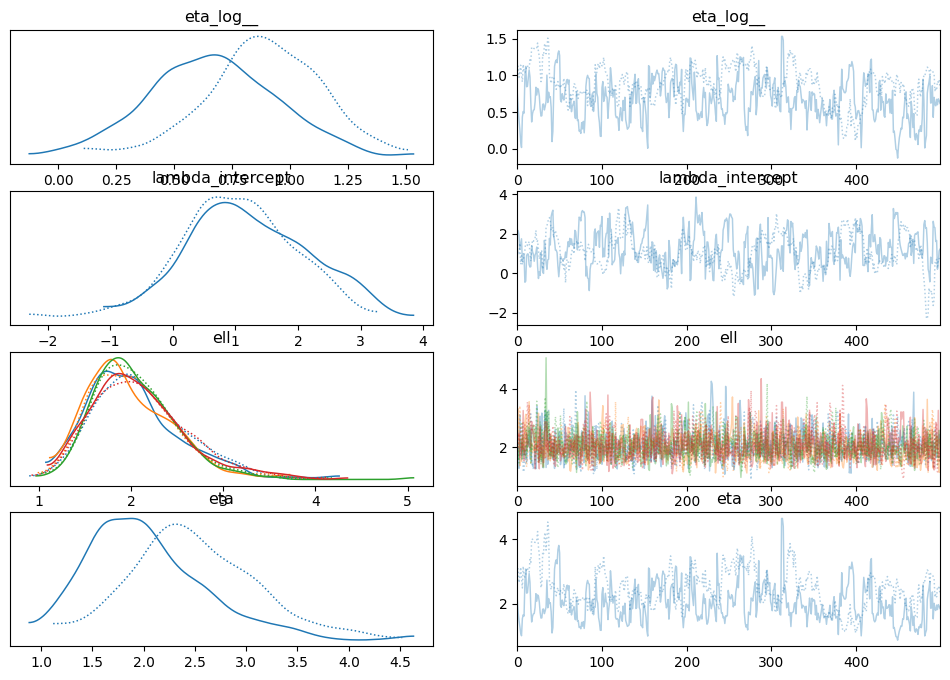

In [128]:
az.plot_trace(trace, var_names=['~ell_log__', '~lambda_det', '~f_rotated_', '~f']);

In [129]:
with model:
    pm.set_data({
        'model_input': X_test,
        'predict': False
    })
    
    f_pred = gp.conditional("f_pred", X_test, jitter=1e-4)
    p_pred = pm.Deterministic("lambda_det_pred", pm.math.exp(lambda_intercept + f_pred))
    
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['lambda_det', "f_pred", "lambda_det_pred"], return_inferencedata=False)
    print(ppc.keys())
    
lambda_det = ppc['lambda_det_pred'].reshape(-1, 28).mean(axis=0)


/tmp/ipykernel_34149/58463900.py:11: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace, var_names=['lambda_det', "f_pred", "lambda_det_pred"], return_inferencedata=False)
Sampling: [f_pred, f_rotated_]


dict_keys(['lambda_det', 'f_pred', 'lambda_det_pred'])


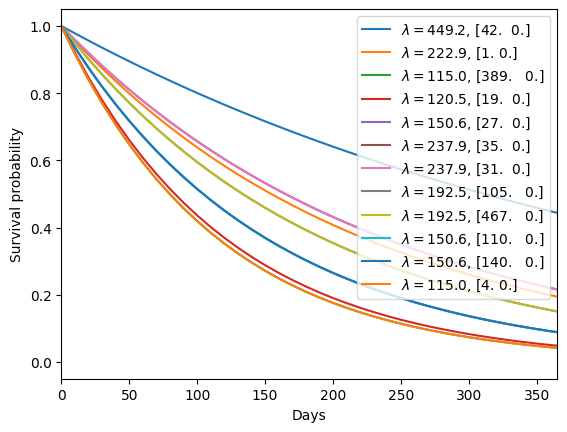

In [130]:
t = np.linspace(0, max(y_train[:,0]), 100)

S0 = sp.stats.expon.sf

for i in range(12):
    sample_lambda = lambda_det[i*2]
    y_true = y_train[i*5]
    plt.plot(t, S0(t / sample_lambda), label = f"$\lambda={round(sample_lambda, 1)}$, {y_true}");
    
plt.ylabel("Survival probability")
plt.xlabel("Days")
# plt.title("Effect of $\kappa$")
plt.legend();
plt.xlim(0, 365);


In [131]:
t = np.linspace(0, max(y_train[:,0]), 100)
num_samples = X_test.shape[0]

t_samples = np.repeat(t, num_samples).reshape((len(t), -1))
median_surv = np.median(t_samples * S0(1 / lambda_det), axis=0)


In [122]:
c_index = lifelines.utils.concordance_index(y_test[:, 0], median_surv, 1-y_test[:, 1])
print(c_index)

0.4835164835164835


# Best model

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values.astype(float)
y_train = y_train.astype(float)
X_test = X_test.values.astype(float)
y_test = y_test.astype(float)

In [7]:
X_test.shape

(28, 9)

In [95]:
# y_train = y.astype(float)
# print(y_train.shape)

with pm.Model() as model3:
    model_input = pm.MutableData("model_input", X_train)
    
    ell = pm.InverseGamma("ell", mu=1.0, sigma=0.5, shape=(n_predictors,))
    eta = pm.Exponential("eta", lam=1.0)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(input_dim=n_predictors, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=model_input)
    
    lambda_intercept = pm.Normal("lambda_intercept",
                                 mu=0, 
                                 sigma=1)
    
    lambda_det = pm.Deterministic("lambda_det", pm.math.exp(f))
    
    y_ = pm.Exponential("y", pm.math.ones_like(y_train[y_train[:, 1] == 0, 0]) / lambda_det[y_train[:, 1] == 0], 
                        observed=y_train[y_train[:, 1] == 0, 0])
    
    def exponential_lccdf(lam, time):
        """ Log complementary cdf of Exponential distribution. """
        return -(lam * time)
    
    y_cens = pm.Potential(
        "y_cens", exponential_lccdf(pm.math.ones_like(y_train[y_train[:, 1] == 1, 0]) / lambda_det[y_train[:, 1] == 1], 
                                    y_train[y_train[:, 1] == 1, 0])
    )
    
    # f_pred = gp.conditional("f_pred", model_input, jitter=1e-4)
    # p_pred = pm.Deterministic("lambda_det_pred", pm.math.exp(lambda_intercept + f_pred))

    trace3 = pm.sampling_jax.sample_numpyro_nuts(draws=1000, tune=500, chains=2, random_seed=1)
    
az.to_netcdf(trace3, filename='saved_numpyro.netcdf')

Compiling...
Compilation time =  0:00:02.155292
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:04:58.966161
Transforming variables...
Transformation time =  0:00:02.372750
Computing Log Likelihood...
Log Likelihood time =  0:00:02.701090


'saved_numpyro.netcdf'

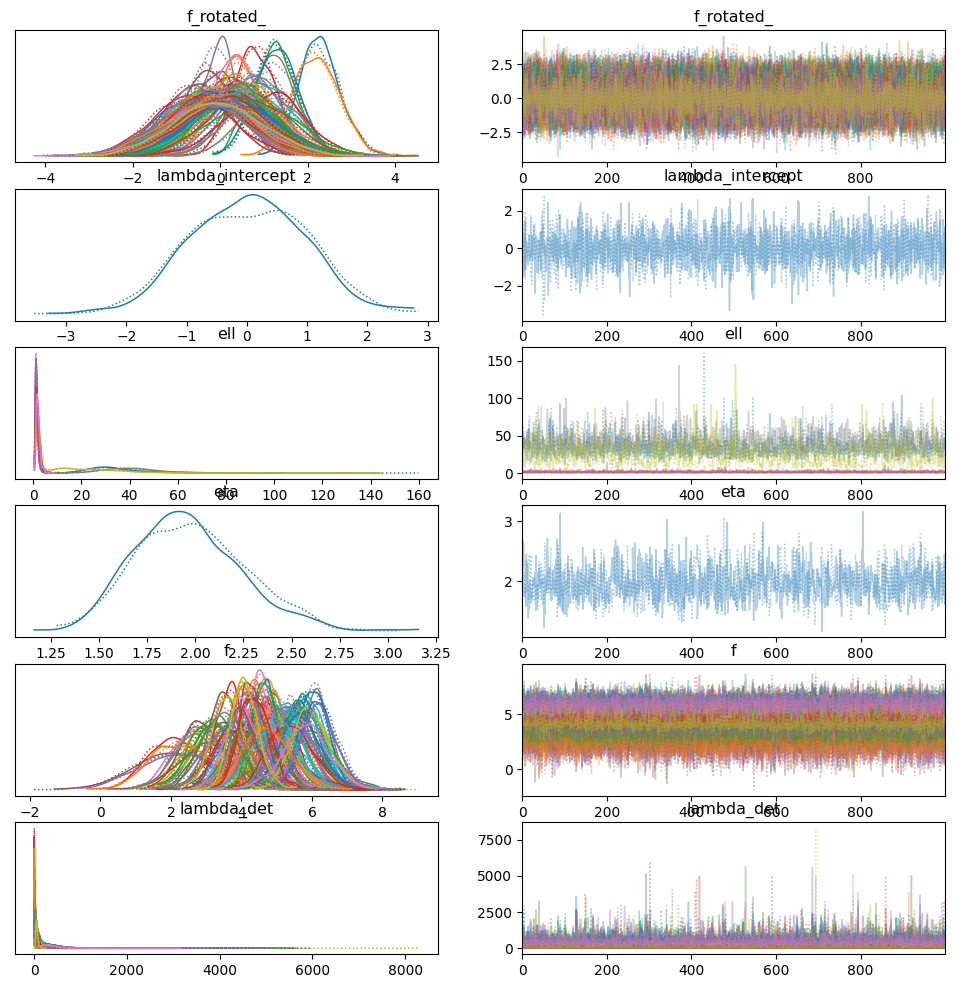

In [96]:
az.plot_trace(trace3);

In [97]:
n_nonconverged = int(np.sum(az.rhat(trace3)[["eta", "ell", "f_rotated_"]].to_array() > 1.03).values)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")


No Rhat values above 1.03, ✓


In [98]:
with model3:
    f_pred = gp.conditional("f_pred", X_test, jitter=1e-4)
    p_pred = pm.Deterministic("lambda_det_pred", pm.math.exp(lambda_intercept + f_pred))


In [99]:

# thinned_idata = trace3.sel(draw=slice(None, None, 1))

with model3:
    ppc = pm.sample_posterior_predictive(trace3, var_names=["f_pred", "lambda_det_pred"], return_inferencedata=False, random_seed=0)

print(ppc.keys(), ppc['lambda_det_pred'].shape)
lambda_det = ppc['lambda_det_pred'].reshape(-1, ppc['lambda_det_pred'].shape[2]).mean(axis=0)
print(lambda_det.shape)

/tmp/ipykernel_673/293602470.py:4: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(trace3, var_names=["f_pred", "lambda_det_pred"], return_inferencedata=False, random_seed=0)
Sampling: [f_pred]
INFO:pymc:Sampling: [f_pred]


dict_keys(['f_pred', 'lambda_det_pred']) (2, 1000, 28)
(28,)


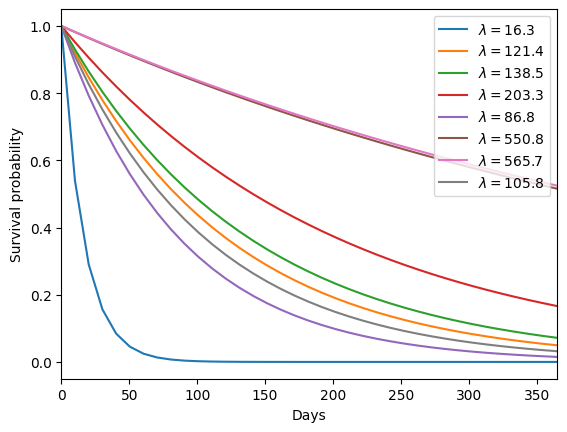

In [100]:
t = np.linspace(0, max(y_test[:,0]), 100)

S0 = sp.stats.expon.sf

for i in range(8):
    sample_lambda = lambda_det[i]
    y_true = y_test[i]
    color = 'blue' if y_true[1] == 1 else 'red'
    plt.plot(t, S0(t / sample_lambda), label = f"$\lambda={round(sample_lambda, 1)}$");
    
plt.ylabel("Survival probability")
plt.xlabel("Days")
# plt.title("Effect of $\kappa$")
plt.legend();
plt.xlim(0, 365);


In [101]:
t = np.linspace(0, max(y_train[:,0]), 100)
num_samples = X_test.shape[0]

t_samples = np.repeat(t, num_samples).reshape((len(t), -1))
median_surv = np.median(t_samples * S0(1 / lambda_det), axis=0)


In [102]:
c_index = lifelines.utils.concordance_index(y_test[:, 0], median_surv, 1-y_test[:, 1])
print(c_index)

0.6785714285714286


In [ ]:
0.6813

In [117]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df

,time,status,karno,diagtime,age,prior,trt,celltype
10,42,1,60,4,81,0,1,1
130,43,1,60,11,49,10,2,4
51,162,1,80,5,64,0,1,3
11,8,1,40,58,63,10,1,1
114,73,1,60,3,70,0,2,3
...,...,...,...,...,...,...,...,...
71,87,0,80,3,48,0,2,1
106,29,1,40,8,67,0,2,2
14,11,1,70,11,48,10,1,1
92,13,1,30,2,62,0,2,2


In [139]:
cph = lifelines.CoxPHFitter()
cph.fit(train_df, duration_col='time', event_col='status', formula="celltype + trt  ")

<lifelines.CoxPHFitter: fitted with 109 total observations, 8 right-censored observations>

In [140]:
cph.score(test_df, scoring_method="concordance_index")

0.4642857142857143